### Performance comparison of SLS and LQR controllers with bound constraints on the control and on the state 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from copy import deepcopy
from time import time
from isls import SLS
from isls.utils import get_double_integrator_AB
from isls.projections import *

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
np.set_printoptions(precision=5, suppress=False)
plt.rcParams["figure.figsize"] = (4,3)
real_min = np.finfo(float).tiny

### Problem setup

In [252]:
x_dim = 1
u_dim = 1
T = 1.
horizon = 100
nb_deriv = 2
N = horizon
dt = T/horizon
print("dt:", dt)
d = x_dim*nb_deriv
A, B = get_double_integrator_AB(x_dim, nb_deriv=nb_deriv, dt=dt)

dt: 0.01


In [253]:
%%time
sls = SLS(d, u_dim, horizon)
sls.AB = [A,B]

Wall time: 3 ms


Define the task:

In [504]:
u_std = 1e-2
x_std = 1e3
x_final_target = np.array([1., 0.])
viaQ_final = np.diag([0, x_std])

free_state = np.zeros(d)
viaQ_free = np.diag([0]*d)

zs = np.stack([free_state,  x_final_target])
Qs = np.stack([viaQ_free,  viaQ_final])

seq = np.zeros(N, dtype=np.int32)
seq[N-1] = 1

In [505]:
sls.set_cost_variables(zs, Qs, seq, u_std)

In [506]:
x0 = np.zeros(d)
x_opt, u_opt = sls.solve_batch(x0)

## ADMM Optimization with state bounds on the given timestep

### Define constraints

In [524]:
list_of_proj_x = []
list_of_proj_u = []

# State constraints
lower_x_final = 1.2
upper_x_final = 1.4
lower_dx = -2.
upper_dx = 2.
def project_state(x):
    x_ = x.reshape(N,d)
    x_[-1, 0] = project_bound(x_[-1,0], lower_x_final, upper_x_final)
    x_[:-1 , 1] = project_bound(x_[:-1 ,1], lower_dx, upper_dx)
    return x_.flatten()
    
list_of_proj_x += [project_state]
    
# Control constraints
lower_u = -5.
upper_u = 5.
nb_proj = 1
list_of_proj_u += [lambda u: project_bound(u, lower_u, upper_u)]    

### Batch LQT - ADMM

ADMM converged at iteration  163 !
ADMM residual is  9.98e-06 1.21e-06
1.2029361152491975
Constrained cost is 2.30e+01
Unconstrained cost is 0.00e+00
Wall time: 188 ms


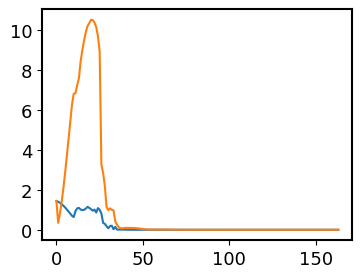

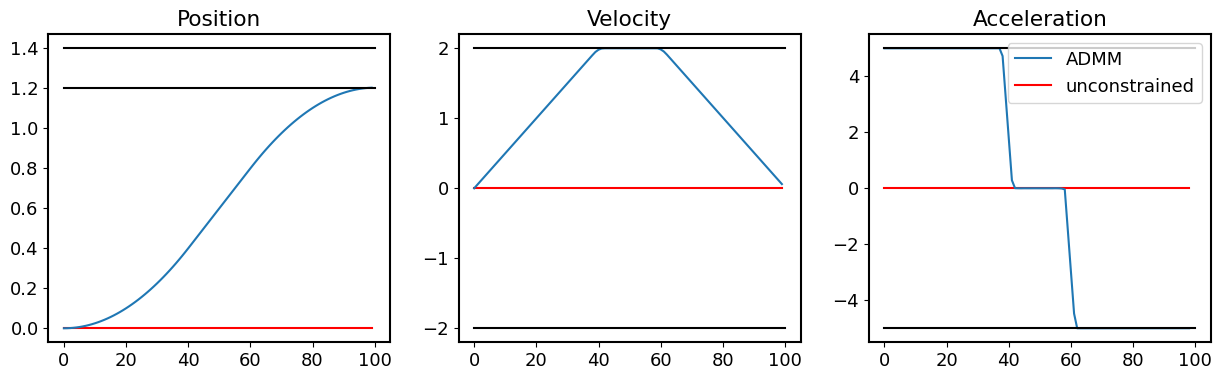

In [527]:
%%time
# Final timestep position and all timestep velocities are constrained.
rho_x = np.zeros((N, d, d))
rho_x[-1, 0, 0] = 1e1 # Final timestep position
rho_x[:-1, 1, 1] = 1e-1# all timestep velocities
rho_x = 1e1
rho_u = 1e-1
alpha = 1.
x_optimal, u_optimal, log = sls.ADMM_LQT_Batch(np.zeros(d), list_of_proj_x=list_of_proj_x,list_of_proj_u=list_of_proj_u, max_iter=1000, 
                                      alpha=alpha,rho_x=rho_x, rho_u=rho_u, threshold=1e-5, verbose=True, log=True)
plt.plot(log)
print(x_optimal[-2])
fig,ax = plt.subplots(ncols=3, figsize=(15,4))
x_optimal = sls.C[:,:d]@x0 + sls.D@u_optimal

ax[0].plot(x_optimal.reshape(N,-1)[:,0], label="ADMM")
ax[0].plot(x_opt[:,0], "r", label="unconstrained", zorder=1)
ax[0].plot([0,N],[lower_x_final]*2, "k")
ax[0].plot([0,N],[upper_x_final]*2, "k")

ax[1].plot(x_optimal.reshape(N,-1)[:,1])
ax[1].plot(x_opt[:,1], "r", zorder=1)
ax[1].plot([0,N],[lower_dx]*2, "k")
ax[1].plot([0,N],[upper_dx]*2, "k")

ax[2].plot(u_optimal.reshape(N,-1)[:-1], label="ADMM")
ax[2].plot(u_opt[:-1], "r", label="unconstrained", zorder=1)
ax[2].plot([0,N*u_dim],[lower_u]*2, "k")
ax[2].plot([0,N*u_dim],[upper_u]*2, "k")
titles = ["Position", "Velocity", "Acceleration"]
for i in range(3):
    ax[i].set_title(titles[i])

plt.legend()
print("Constrained cost is", "{:.2e}".format(sls.compute_cost(x_optimal, u_optimal)))
print("Unconstrained cost is", "{:.2e}".format(sls.compute_cost(x_opt, u_opt)))

Constrained cost is 2.31e+01
Unconstrained cost is 0.00e+00
Wall time: 332 ms


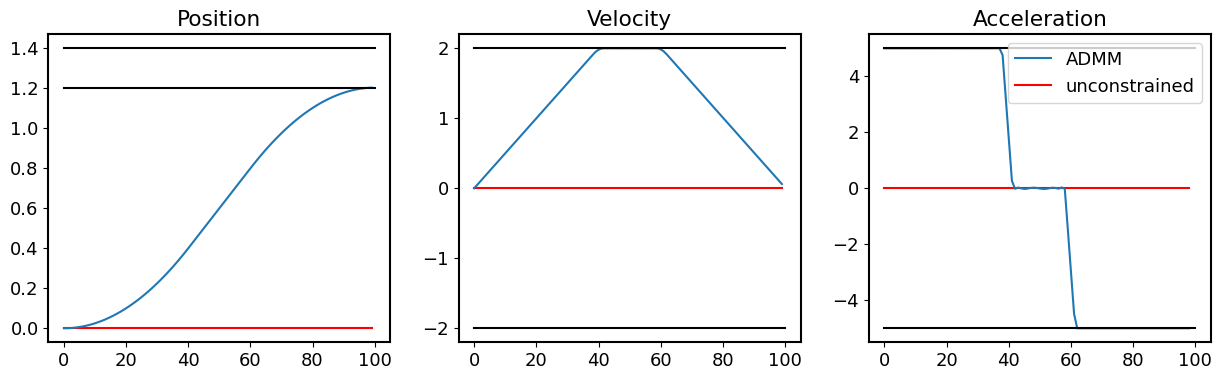

In [528]:
%%time

x_optimal, u_optimal,  K_optimal, k_optimal ,log_DP = sls.ADMM_LQT_DP(np.zeros(d), list_of_proj_x=list_of_proj_x, list_of_proj_u=list_of_proj_u,
                                                          max_iter=5000,  rho_x=rho_x, rho_u=rho_u, threshold=1e-4, verbose=False, log=True)
fig,ax = plt.subplots(ncols=3, figsize=(15,4))
x_optimal = sls.C[:,:d]@x0 + sls.D@u_optimal
ax[0].plot(x_optimal.reshape(N,-1)[:,0], label="ADMM")
ax[0].plot(x_opt[:,0], "r", label="unconstrained", zorder=1)
ax[0].plot([0,N],[lower_x_final]*2, "k")
ax[0].plot([0,N],[upper_x_final]*2, "k")

ax[1].plot(x_optimal.reshape(N,-1)[:,1])
ax[1].plot(x_opt[:,1], "r", zorder=1)
ax[1].plot([0,N],[lower_dx]*2, "k")
ax[1].plot([0,N],[upper_dx]*2, "k")

ax[2].plot(u_optimal.reshape(N,-1)[:-1], label="ADMM")
ax[2].plot(u_opt[:-1], "r", label="unconstrained", zorder=1)
ax[2].plot([0,N*u_dim],[lower_u]*2, "k")
ax[2].plot([0,N*u_dim],[upper_u]*2, "k")
titles = ["Position", "Velocity", "Acceleration"]
for i in range(3):
    ax[i].set_title(titles[i])

plt.legend()
print("Constrained cost is", "{:.2e}".format(sls.compute_cost(x_optimal, u_optimal)))
print("Unconstrained cost is", "{:.2e}".format(sls.compute_cost(x_opt, u_opt)))

In [584]:
mu

array([1., 0.])

In [585]:
cu

array([-0.60796, -0.     ])

In [587]:
du

3.0397841595588457

In [590]:
from scipy.stats import norm

# For robust constraints only for x0's position, z has dim 1+x_dim
x0_pos = np.zeros(x_dim)
mu = np.zeros(x_dim + 1) # [1, x0]
mu[0] = 1. 
mu[1:] = x0_pos

var_x0 = 0.01
sigma = np.zeros(x_dim + 1)
sigma[0] = 0. # first term is deterministic and equal to one.
sigma[1:] = var_x0 # variance for the x0
psi_inv = norm.ppf(0.95)
psi_inv = norm.ppf(0.5)+1e-100 # should be the same as expected
 
Au = np.diag(np.sqrt(sigma))
bu = np.zeros(Au.shape[0])
cu = -mu/psi_inv
du = upper_u/psi_inv

Al = Au
bl = bu
cl = mu/psi_inv
dl = -lower_u/psi_inv

As = [Au, Al]
bs = [bu, bl]
cs = [cu, cl]
ds = [du, dl]


nb_proj = 2 # nb of projections needed for each row of psi_u
list_of_proj_u = []
def make_function(i):
    def f(y):
        return project_soc(y, As[i], bs[i], cs[i], ds[i])
    return f

for i in range(nb_proj):
    list_of_proj_u += [make_function(i)]
    
    
#####################################################################

# For robust constraints only for x0's position, z has dim 1+x_dim
ds_x_final = [upper_x_final/psi_inv, -lower_x_final/psi_inv]
ds_dx = [upper_dx/psi_inv, -lower_dx/psi_inv]

nb_proj = 2 # nb of projections needed for each row of psi_x
def make_function2(i):
    def f2(y):
        y[-2] = project_soc(y[-2], As[i], bs[i], cs[i], ds_x_final[i])
        # y[1::d] = project_soc(y[1::d], As[i], bs[i], cs[i], ds_dx[i])
        return y
    return f2
list_of_proj_x = []
for i in range(nb_proj):
    list_of_proj_x += [make_function2(i)]

Start iterating..
Residual is  3.03e+01 1.09e-03
Max iteration reached.
Constrained cost is 2.47e+02
Unconstrained cost is 0.00e+00
Wall time: 4.45 s


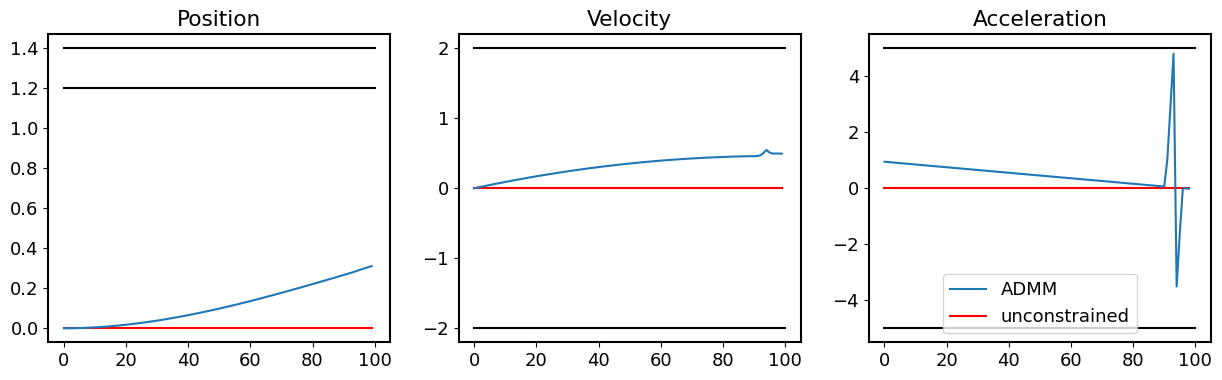

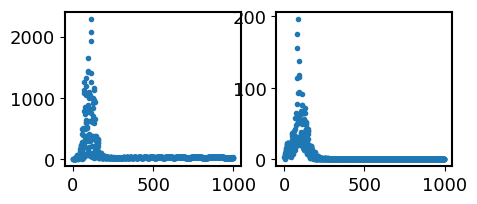

In [593]:
%%time
# Final timestep position and all timestep velocities are constrained.
rho_x = np.zeros((N, d, d))
rho_x[-1, 0, 0] = 1e-1 # Final timestep position
rho_x[:, 1, 1] = 0 # all timestep velocities
rho_x = 1e1
rho_u = 1e-1

alpha = 1.
x0 = np.zeros(d)
max_iter = 1000
du, PHI_U,log = sls.ADMM(list_of_proj_u=list_of_proj_u,
                         list_of_proj_x=list_of_proj_x,
                         max_iter=max_iter, rho_x=rho_x, rho_u=rho_u,  alpha=alpha, threshold=1e-2, verbose=0, log=True)
u_optimal = du.copy()
fig,ax = plt.subplots(ncols=3, figsize=(15,4))
x_optimal = sls.C[:,:d]@x0 + sls.D@u_optimal
ax[0].plot(x_optimal.reshape(N,-1)[:,0], label="ADMM")
ax[0].plot(x_opt[:,0], "r", label="unconstrained", zorder=1)
ax[0].plot([0,N],[lower_x_final]*2, "k")
ax[0].plot([0,N],[upper_x_final]*2, "k")

ax[1].plot(x_optimal.reshape(N,-1)[:,1])
ax[1].plot(x_opt[:,1], "r", zorder=1)
ax[1].plot([0,N],[lower_dx]*2, "k")
ax[1].plot([0,N],[upper_dx]*2, "k")

ax[2].plot(u_optimal.reshape(N,-1)[:-1], label="ADMM")
ax[2].plot(u_opt[:-1], "r", label="unconstrained", zorder=1)
ax[2].plot([0,N*u_dim],[lower_u]*2, "k")
ax[2].plot([0,N*u_dim],[upper_u]*2, "k")
titles = ["Position", "Velocity", "Acceleration"]
for i in range(3):
    ax[i].set_title(titles[i])

plt.legend()
print("Constrained cost is", "{:.2e}".format(sls.compute_cost(x_optimal, u_optimal)))
print("Unconstrained cost is", "{:.2e}".format(sls.compute_cost(x_opt, u_opt)))
fig,ax= plt.subplots(ncols=2, figsize=(5,2))
ax[0].plot(np.stack(log)[:,0], ".")
ax[1].plot(np.stack(log)[:,1], ".")

### Experiment 1: Try 10000 different initial states and compare the statistics of success with the one that is provided to the robust optimal controller

In [537]:
noise_scale = 0.0
scale_x0 = np.sqrt(var_x0)
nb_experiments = 10000

x_logs = np.zeros((2, nb_experiments, N,  x_dim*nb_deriv))
u_logs = np.zeros((2, nb_experiments, N,  u_dim))

x0s = np.zeros((nb_experiments, d))
x0s[:, :x_dim] = np.random.normal(loc=np.zeros(x_dim), scale=scale_x0, size=(nb_experiments, x_dim))

x_logs[0], u_logs[0] = sls.get_trajectory_dp(x0s, K_optimal, k_optimal, noise_scale=noise_scale)

K_sls, k_sls = sls.controller(PHI_U, du)
x_logs[1], u_logs[1] = sls.get_trajectory_sls(x0s, K_sls, k_sls, noise_scale=noise_scale)

In [538]:
thr = 0.
names = ["DP", "SLS"]
for i in range(2):
    s1 = lower_x_final - thr <= x_logs[i,:,-1,0]
    s1 = s1 * (x_logs[i,:,-1,0] <= upper_x_final + thr)
    s2 = np.sum(lower_u - thr <= u_logs[i,:,:,:], axis=(1,2))/(N*u_dim)
    s2 = s2 * np.sum(u_logs[i,:,:,:] <= upper_u + thr, axis=(1,2))/(N*u_dim)
    s3 = lower_dx - thr <= x_logs[i,:,-1,1]
    s3 = s3 * (x_logs[i,:,-1,1] <= upper_dx + thr)
    print("Percentage of success for", names[i], 100*np.sum(s2*s1*s3)/nb_experiments)

Percentage of success for DP 43.813365999999995
Percentage of success for SLS 0.0


### Experiment 2: Compare DP solution (non-robust) and SLS solution (robust)

In [496]:
noise_scale = 0.0
scale_x0 = np.sqrt(var_x0)
nb_experiments = 5

x_logs = np.zeros((2, nb_experiments, N,  x_dim*nb_deriv))
u_logs = np.zeros((2, nb_experiments, N,  u_dim))

x0s = np.zeros((nb_experiments, d))
x0s[:, :x_dim] = np.random.normal(loc=np.zeros(x_dim), scale=scale_x0, size=(nb_experiments, x_dim))

x_logs[0], u_logs[0] = sls.get_trajectory_dp(x0s, K_optimal, k_optimal, noise_scale=noise_scale)

K_sls, k_sls = sls.controller(PHI_U, du)
x_logs[1], u_logs[1] = sls.get_trajectory_sls(x0s, K_sls, k_sls, noise_scale=noise_scale)
thr = 0.
names = ["DP", "SLS"]
for i in range(2):
    s1 = lower_x_final - thr <= x_logs[i,:,-1,0]
    s1 = s1 * (x_logs[i,:,-1,0] <= upper_x_final + thr)
    s2 = np.sum(lower_u - thr <= u_logs[i,:,:,:], axis=(1,2))/(N*u_dim)
    s2 = s2 * np.sum(u_logs[i,:,:,:] <= upper_u + thr, axis=(1,2))/(N*u_dim)
    s3 = lower_dx - thr <= x_logs[i,:,-1,1]
    s3 = s3 * (x_logs[i,:,-1,1] <= upper_dx + thr)
    print("Percentage of success for", names[i], 100*np.sum(s2*s1*s3)/nb_experiments)

Percentage of success for DP 60.0
Percentage of success for SLS 100.0


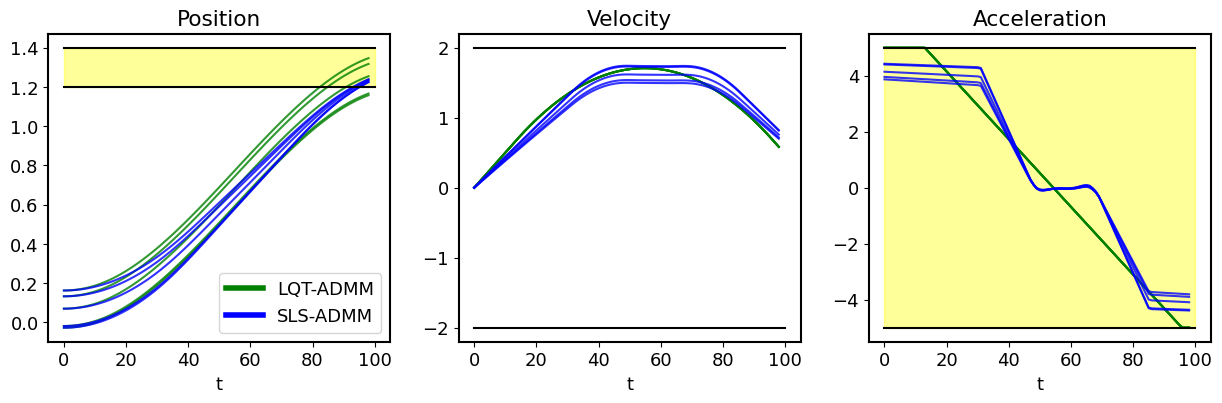

In [497]:
colors = ["g", "b", "orange"]
fig,axes_ = plt.subplots(nrows=x_dim, ncols=3, figsize=(15,4))
if x_dim == 1: axes_ = [axes_]

# vias = [via1, via2, via1_, via2_]
# times = [via_time1, via_time2, via_time1_, via_time2_ ]
titles = ["Position", "Velocity", "Acceleration"]
ylabels = np.array([[r"$x$",r"$\dot{x}$",r"$\ddot{x}$"],[r"$y$",r"$\dot{y}$",r"$\ddot{y}$"]])
label =[r"$V_1$", r"$V_2$",r"$VN_1$",r"$VN_2$",]
markers = ["_", "_", "_", "_"]
colors_markers = ["r", "r", "magenta", "magenta"]

changed = True
lw = 15
for dim,axes in enumerate(axes_):

    # axes[0].scatter(horizon-1, x_final_target[0],marker="x", color="k")
    logs = np.concatenate((x_logs, u_logs), -1)
    for i in range(3):
        for cnt,log in enumerate(logs):
            axes[i].plot(log[:, :-1, i*x_dim+dim].T,color=colors[cnt], alpha=0.8)  
        # axes[i].set_ylabel(ylabels[dim,i])
        axes[i].set_xlabel("t")
        axes[i].set_title(titles[i])
# axes[0].set_ylim([-1,1])

axes[0].plot([0,N],[lower_x_final]*2, "k")
axes[0].plot([0,N],[upper_x_final]*2, "k")
axes[1].plot([0,N],[lower_dx]*2, "k")
axes[1].plot([0,N],[upper_dx]*2, "k")
axes[2].plot([0,N],[lower_u]*2, "k")
axes[2].plot([0,N],[upper_u]*2, "k")

axes[0].fill_between([0,100], lower_x_final, upper_x_final, alpha=0.4, color="yellow", label="constraint")
axes[2].fill_between([0,100], lower_u, upper_u, alpha=0.4, color="yellow", label="constraint")


# from matplotlib.lines import Line2D
from matplotlib.lines import Line2D  
custom_lines = [Line2D([0], [0], color=colors[i], lw=4) for i in range(len(colors))]

axes[0].legend(custom_lines, ['LQT-ADMM', 'SLS-ADMM'])